In [3]:
import sys
from pathlib import Path
import os
import pickle
import random
import shutil

import glob2 as glob
import tensorflow as tf
from azureml.core import Experiment, Workspace
from azureml.core.run import Run
from tensorflow.keras import callbacks

sys.path.append(str(Path(os.getcwd()) / 'src'))

from config import CONFIG
from constants import REPO_DIR
from model import create_cnn

sys.path.append(str(REPO_DIR / 'src/common'))

from model_utils.preprocessing import preprocess_depthmap, preprocess_targets
from model_utils.lr_finder import LRFinder

In [4]:
# Make experiment reproducible
tf.random.set_seed(CONFIG.SPLIT_SEED)
random.seed(CONFIG.SPLIT_SEED)

# Get the current run.
run = Run.get_context()

# Offline run. Download the sample dataset and run locally. Still push results to Azure.
if(run.id.startswith("OfflineRun")):
    print("Running in offline mode...")

    # Access workspace.
    print("Accessing workspace...")
    workspace = Workspace.from_config()
    experiment = Experiment(workspace, "training-junkyard")
    run = experiment.start_logging(outputs=None, snapshot_directory=None)

    # Get dataset.
    print("Accessing dataset...")
    dataset_name = "anon-depthmap-mini"
    dataset_path = str(REPO_DIR / "data" / dataset_name)
    if not os.path.exists(dataset_path):
        dataset = workspace.datasets[dataset_name]
        dataset.download(target_path=dataset_path, overwrite=False)

# Online run. Use dataset provided by training notebook.
else:
    print("Running in online mode...")
    experiment = run.experiment
    workspace = experiment.workspace
    dataset_path = run.input_datasets["dataset"]

Running in offline mode...
Accessing workspace...
Accessing dataset...


In [5]:
# Get the QR-code paths.
dataset_path = os.path.join(dataset_path, "scans")
print("Dataset path:", dataset_path)
#print(glob.glob(os.path.join(dataset_path, "*"))) # Debug
print("Getting QR-code paths...")
qrcode_paths = glob.glob(os.path.join(dataset_path, "*"))
print("qrcode_paths: ", len(qrcode_paths))
assert len(qrcode_paths) != 0

# Shuffle and split into train and validate.
random.shuffle(qrcode_paths)
split_index = int(len(qrcode_paths) * 0.8)
qrcode_paths_training = qrcode_paths[:split_index]
qrcode_paths_validate = qrcode_paths[split_index:]
qrcode_paths_activation = random.choice(qrcode_paths_validate)
qrcode_paths_activation = [qrcode_paths_activation]

del qrcode_paths

# Show split.
print("Paths for training:")
print("\t" + "\n\t".join(qrcode_paths_training))
print("Paths for validation:")
print("\t" + "\n\t".join(qrcode_paths_validate))
print("Paths for activation:")
print("\t" + "\n\t".join(qrcode_paths_activation))

print(len(qrcode_paths_training))
print(len(qrcode_paths_validate))

assert len(qrcode_paths_training) > 0 and len(qrcode_paths_validate) > 0


def get_depthmap_files(paths):
    pickle_paths = []
    for path in paths:
        pickle_paths.extend(glob.glob(os.path.join(path, "**", "*.p")))
    return pickle_paths


# Get the pointclouds.
print("Getting depthmap paths...")
paths_training = get_depthmap_files(qrcode_paths_training)
paths_validate = get_depthmap_files(qrcode_paths_validate)
paths_activate = get_depthmap_files(qrcode_paths_activation)

del qrcode_paths_training
del qrcode_paths_validate
del qrcode_paths_activation

print("Using {} files for training.".format(len(paths_training)))
print("Using {} files for validation.".format(len(paths_validate)))
print("Using {} files for validation.".format(len(paths_activate)))


# Function for loading and processing depthmaps.
def tf_load_pickle(path, max_value):
    def py_load_pickle(path, max_value):
        depthmap, targets = pickle.load(open(path.numpy(), "rb"))
        depthmap = preprocess_depthmap(depthmap)
        depthmap = depthmap / max_value
        depthmap = tf.image.resize(depthmap, (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH))
        targets = preprocess_targets(targets, CONFIG.TARGET_INDEXES)
        return depthmap, targets

    depthmap, targets = tf.py_function(py_load_pickle, [path, max_value], [tf.float32, tf.float32])
    depthmap.set_shape((CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, 1))
    targets.set_shape((len(CONFIG.TARGET_INDEXES,)))
    return depthmap, targets


def tf_flip(image):
    image = tf.image.random_flip_left_right(image)
    return image

Dataset path: /Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans
Getting QR-code paths...
qrcode_paths:  200
Paths for training:
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1585000019-syglokl9nx
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1585359302-xgr04tzu1x
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1585004555-pdy6rqar2k
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1583465004-e08aft4qoi
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1585015338-j5bywnvx0m
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1585004959-pa1bzmqc2z
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1583464407-99ik4m3cuf
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1585119077-65v2b8mgz4
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-mini/scans/1585296863-bs7f3iy4ah
	/Users/markus/Development/cgm/cgm-ml/data/an

In [6]:
# Create dataset for training.
paths = paths_training
dataset = tf.data.Dataset.from_tensor_slices(paths)
dataset_norm = dataset.map(lambda path: tf_load_pickle(path, CONFIG.NORMALIZATION_VALUE))
dataset_norm = dataset_norm.cache()
dataset_norm = dataset_norm.prefetch(tf.data.experimental.AUTOTUNE)
dataset_norm = dataset_norm.shuffle(CONFIG.SHUFFLE_BUFFER_SIZE)
dataset_training = dataset_norm
del dataset_norm

# Create dataset for validation.
# Note: No shuffle necessary.
paths = paths_validate
dataset = tf.data.Dataset.from_tensor_slices(paths)
dataset_norm = dataset.map(lambda path: tf_load_pickle(path, CONFIG.NORMALIZATION_VALUE))
dataset_norm = dataset_norm.cache()
dataset_norm = dataset_norm.prefetch(tf.data.experimental.AUTOTUNE)
dataset_validation = dataset_norm
del dataset_norm

# Create dataset for activation
paths = paths_activate
dataset = tf.data.Dataset.from_tensor_slices(paths)
dataset_norm = dataset.map(lambda path: tf_load_pickle(path, CONFIG.NORMALIZATION_VALUE))
dataset_norm = dataset_norm.cache()
dataset_norm = dataset_norm.prefetch(tf.data.experimental.AUTOTUNE)
dataset_activation = dataset_norm
del dataset_norm

# Note: Now the datasets are prepared.

# Create the model.
input_shape = (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, 1)
model = create_cnn(input_shape, dropout=True)

In [7]:
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

# LR Find

Epoch 1/5
13/13 - 291s - loss: 138.4882 - mae: 11.5423
Epoch 2/5
13/13 - 292s - loss: 138.4465 - mae: 11.5405
Epoch 3/5
13/13 - 275s - loss: 135.6568 - mae: 11.4193
Epoch 4/5
13/13 - 258s - loss: 107.5898 - mae: 9.3551
Epoch 5/5
13/13 - 291s - loss: 141.4453 - mae: 11.3065


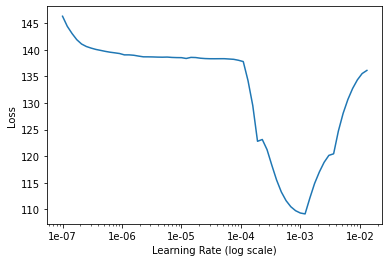

In [8]:
lr_finder = LRFinder()
_ = model.fit(dataset_training.batch(CONFIG.BATCH_SIZE), epochs=5, callbacks=[lr_finder], verbose=2)
lr_finder.plot()

In [9]:
len(dataset_training)

3288

In [10]:
dataset_name

'anon-depthmap-mini'